# 1-2) 상권 클러스터링 (매출과 인구 고려, 추천 상권 도출) - 상은


## 공유컵 사업 참여 추천 지역, 범위 설정
  ### 1) 매출+인구 고려 - 상권 데이터
        매출이 높고 인구가 많은 상권을 알아내자!
            - 유동인구 고려하는 이유: 테이크 아웃 인원 파악 위함
            - 20/30대 매출 건수, (생활인구 또는) 직장인구 데이터 사용
   - 1-1) 클러스터링 진행 - 거리가 가까운 상권의 경우를 클러스터링 해서, 값을 합쳐 새로운 행을 생성. (지헌) 
   - 1-2) 클러스터링 진행 - 매출과 인구를 고려한 클러스터링 (상은)
   - **추천 상권 도출
        
  ### 2) 위치+밀집도 고려 - 소상공인 카페 데이터
        카페 밀집도가 높은 지역 (가까운 거리 안에, 많은 카페가 존재하는) 을 알아내자!
        
   - 2-1) 클러스터링 진행 - 위치와 밀집도 고려해서 카페 밀집된 구역 추천 (수민)
   - **추천 지역 도출
        
        
#### ⇒  결론: 두 고려사항을 충족하는 지역 = 공유컵 시행 최적 지역 을 찾기 위함

In [17]:
import pandas as pd
import numpy as np

import seaborn as sns
import math
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

In [2]:
path = "../../데이터분석 공모전/2021 공공빅데이터 공모전/cup_sharing/"

# 1. 2030 매출, 직장인구 기반 상권 클러스터링


## 1) 데이터 준비

In [41]:
data=pd.read_csv("comarea_result_0.97.csv")
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  646 non-null    int64  
 1   상권_코드_명     646 non-null    object 
 2   분기당_매출_건수   646 non-null    float64
 3   20_30_매출    646 non-null    float64
 4   점포수         646 non-null    float64
 5   총_생활인구_수    646 non-null    float64
 6   총_직장인구_수    646 non-null    float64
 7   longitude   646 non-null    float64
 8   latitude    646 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 45.5+ KB


,Unnamed: 0,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
0,0,동대문패션타운 관광특구,637312.0,405782.0,164.0,9466745.0,10966.0,127.011025,37.567312
1,1,명동 남대문 북창동 다동 무교동 관광특구,3686686.0,1984261.0,542.0,5059404.0,172521.0,126.981856,37.564149
2,2,길동복조리시장,598236.0,304815.0,215.0,28606766.0,11714.0,127.143675,37.538447


In [4]:
data.describe()

,Unnamed: 0,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
count,949.000000,9.490000e+02,9.490000e+02,949.000000,9.490000e+02,949.000000,949.000000,949.000000
mean,474.000000,7.517576e+04,4.507489e+04,14.776607,7.991610e+05,2322.563751,126.988230,37.543343
std,274.097002,1.738372e+05,1.083199e+05,27.261831,9.080861e+05,6422.468571,0.083471,0.047851
min,0.000000,6.000000e+00,0.000000e+00,0.000000,8.886000e+03,2.000000,126.808278,37.441035
25%,237.000000,5.299000e+03,2.629000e+03,4.000000,3.561460e+05,179.000000,126.918038,37.504498
50%,474.000000,1.766400e+04,9.925000e+03,7.000000,5.862010e+05,439.000000,127.000057,37.541684
75%,711.000000,6.010500e+04,3.428100e+04,14.000000,9.065200e+05,1427.000000,127.051436,37.573737
max,948.000000,2.161255e+06,1.334901e+06,360.000000,1.306358e+07,104830.000000,127.171711,37.689128


In [42]:
data["상권_코드_명"].value_counts()

동대문패션타운 관광특구    1
까치산로4길          1
오목로5길           1
신월로15길          1
목동중앙본로7길        1
               ..
양재대로72길         1
양재대로64길         1
양재대로62길         1
송파대로30길         1
명륜길             1
Name: 상권_코드_명, Length: 646, dtype: int64

In [43]:
data["2030매출건수비중"]=data["20_30_매출"]/data["분기당_매출_건수"]
data["직장인구 비중"]=data["총_직장인구_수"]/data["분기당_매출_건수"]

In [44]:
data[data["점포수"]==0]

,Unnamed: 0,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude,2030매출건수비중,직장인구 비중
320,320,대림로7길,6.0,6.0,0.0,243502.0,49.0,126.904035,37.489148,1.0,8.166667


In [45]:
data["점포수"][data["점포수"]==0]=1

In [46]:
data[data["점포수"]==0]

,Unnamed: 0,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude,2030매출건수비중,직장인구 비중


In [47]:
data["2030매출건수_점포"]=data["20_30_매출"]/data["점포수"]
data["직장인구수_점포"]=data["총_직장인구_수"]/data["점포수"]

In [48]:
data["2030매출건수비중_점포"]=data["2030매출건수비중"]/data["점포수"]
data["직장인구 비중_점포"]=data["직장인구 비중"]/data["점포수"]

In [12]:
data.head()

,Unnamed: 0,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude,2030매출건수비중,직장인구 비중,2030매출건수_점포,직장인구수_점포,2030매출건수비중_점포,직장인구 비중_점포
0,0,이태원 관광특구,655230.0,456752.0,157.0,3201926.0,9012.0,126.994377,37.534435,0.697087,0.013754,2909.248408,57.401274,0.004440,0.000088
1,1,둔촌역전통시장,66596.0,34257.0,42.0,3866910.0,2111.0,127.135464,37.527726,0.514400,0.031699,815.642857,50.261905,0.012248,0.000755
2,2,암사종합시장,52565.0,26245.0,25.0,2328002.0,1361.0,127.129134,37.550934,0.499287,0.025892,1049.800000,54.440000,0.019971,0.001036
3,3,낙성대시장,285973.0,208465.0,84.0,5380619.0,3229.0,126.956145,37.478186,0.728967,0.011291,2481.726190,38.440476,0.008678,0.000134
4,4,봉천중앙시장,47645.0,32090.0,26.0,2105071.0,685.0,126.954468,37.484304,0.673523,0.014377,1234.230769,26.346154,0.025905,0.000553


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     646 non-null    int64  
 1   상권_코드_명        646 non-null    object 
 2   분기당_매출_건수      646 non-null    float64
 3   20_30_매출       646 non-null    float64
 4   점포수            646 non-null    float64
 5   총_생활인구_수       646 non-null    float64
 6   총_직장인구_수       646 non-null    float64
 7   longitude      646 non-null    float64
 8   latitude       646 non-null    float64
 9   2030매출건수비중     646 non-null    float64
 10  직장인구 비중        646 non-null    float64
 11  2030매출건수_점포    646 non-null    float64
 12  직장인구수_점포       646 non-null    float64
 13  2030매출건수비중_점포  646 non-null    float64
 14  직장인구 비중_점포     646 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 75.8+ KB


In [ ]:
pd.DataFrame(kmeans.labels_)

In [76]:
pd.concat([pd.DataFrame(kmeans.labels_),data],axis=1).to_excel('road_clu.xlsx')

In [74]:
c1=pd.concat([pd.DataFrame(kmeans.labels_),data],axis=1) 
c1

,0,상권_코드_명
0,2,동대문패션타운 관광특구
1,1,명동 남대문 북창동 다동 무교동 관광특구
2,2,길동복조리시장
3,4,암사종합시장
4,4,잠실 관광특구
...,...,...
641,0,북촌로5나길
642,5,북촌로5길
643,0,북촌로11길
644,0,백석동길


In [75]:
c1[(c1[0]==1)|(c1[0]==3)]
#here

,0,상권_코드_명
1,1,명동 남대문 북창동 다동 무교동 관광특구
5,3,영동전통시장
37,3,서교시장
43,1,압구정 로데오거리_2
47,1,강남 마이스 관광특구


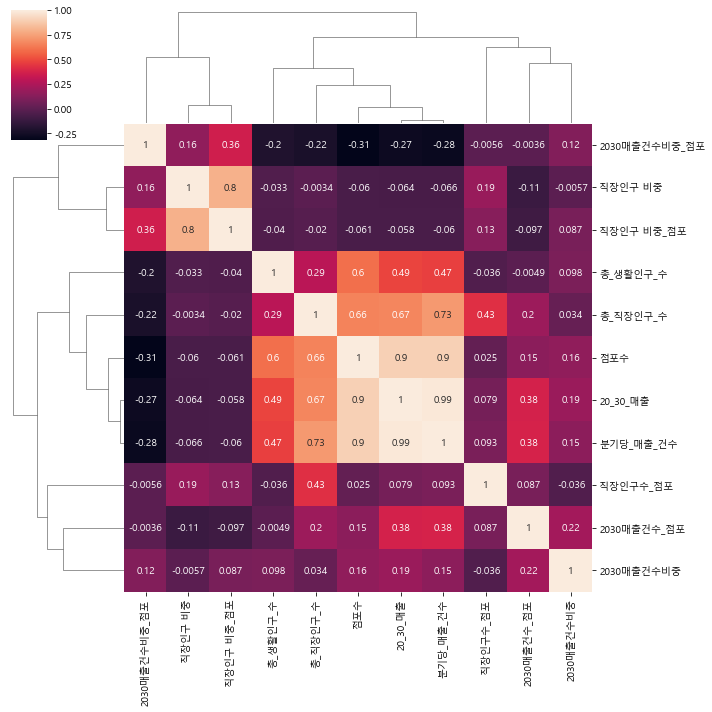

In [13]:
interest_df = data[data.columns.difference(["상권_코드_명","Unnamed: 0",'longitude','latitude'])].corr()

sns.clustermap(interest_df, annot = True)

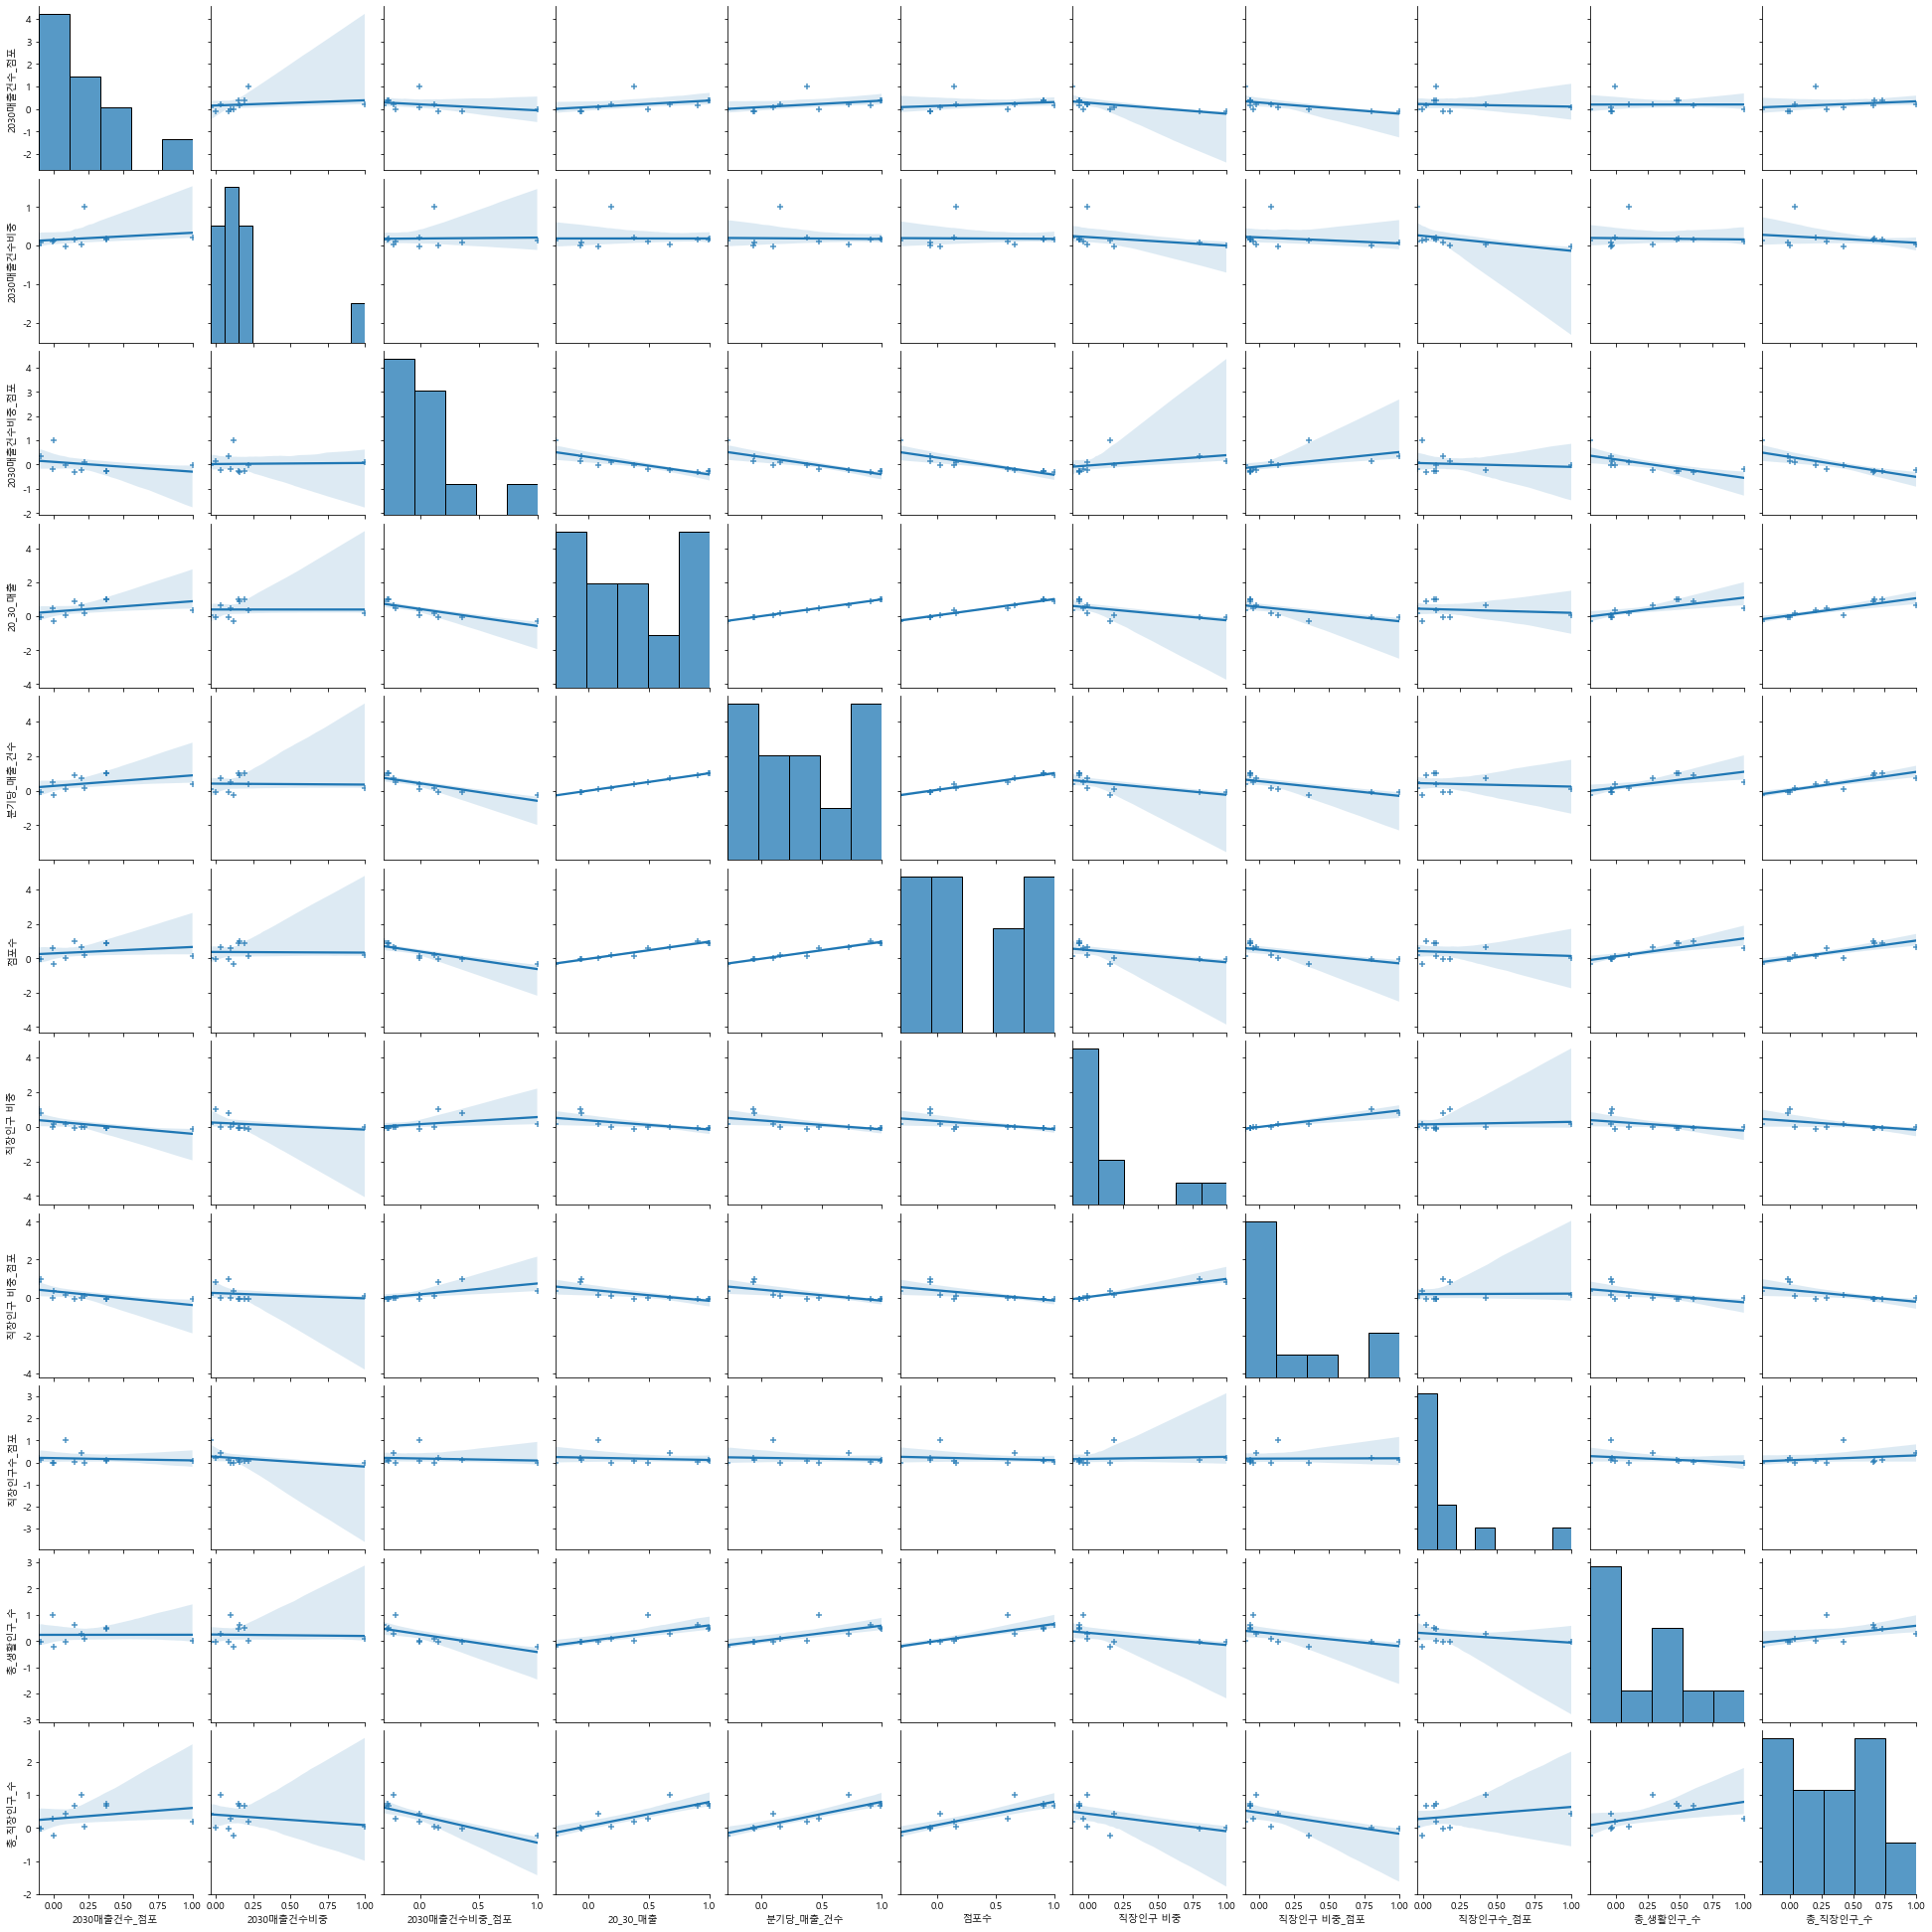

In [14]:
g = sns.pairplot(interest_df, kind = 'reg', markers = '+')

In [50]:
data.columns

Index(['Unnamed: 0', '상권_코드_명', '분기당_매출_건수', '20_30_매출', '점포수', '총_생활인구_수',
       '총_직장인구_수', 'longitude', 'latitude', '2030매출건수비중', '직장인구 비중',
       '2030매출건수_점포', '직장인구수_점포', '2030매출건수비중_점포', '직장인구 비중_점포'],
      dtype='object')

## 2)상권 클러스터링 

In [52]:
from sklearn.cluster import KMeans

In [55]:
data.head()
data.info()

,Unnamed: 0,상권_코드_명,분기당_매출_건수,20_30_매출,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude,2030매출건수비중,직장인구 비중,2030매출건수_점포,직장인구수_점포,2030매출건수비중_점포,직장인구 비중_점포
0,0,동대문패션타운 관광특구,637312.0,405782.0,164.0,9466745.0,10966.0,127.011025,37.567312,0.636709,0.017207,2474.280488,66.865854,0.003882,0.000105
1,1,명동 남대문 북창동 다동 무교동 관광특구,3686686.0,1984261.0,542.0,5059404.0,172521.0,126.981856,37.564149,0.538223,0.046796,3660.998155,318.304428,0.000993,0.000086
2,2,길동복조리시장,598236.0,304815.0,215.0,28606766.0,11714.0,127.143675,37.538447,0.509523,0.019581,1417.744186,54.483721,0.002370,0.000091
3,3,암사종합시장,739289.0,421437.0,242.0,19900216.0,21477.0,127.129134,37.550934,0.570057,0.029051,1741.475207,88.747934,0.002356,0.000120
4,4,잠실 관광특구,753573.0,464046.0,121.0,6358907.0,29779.0,127.115275,37.516476,0.615794,0.039517,3835.090909,246.107438,0.005089,0.000327


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     646 non-null    int64  
 1   상권_코드_명        646 non-null    object 
 2   분기당_매출_건수      646 non-null    float64
 3   20_30_매출       646 non-null    float64
 4   점포수            646 non-null    float64
 5   총_생활인구_수       646 non-null    float64
 6   총_직장인구_수       646 non-null    float64
 7   longitude      646 non-null    float64
 8   latitude       646 non-null    float64
 9   2030매출건수비중     646 non-null    float64
 10  직장인구 비중        646 non-null    float64
 11  2030매출건수_점포    646 non-null    float64
 12  직장인구수_점포       646 non-null    float64
 13  2030매출건수비중_점포  646 non-null    float64
 14  직장인구 비중_점포     646 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 75.8+ KB


In [56]:
df_sca = data[data.columns.difference(["상권_코드_명","Unnamed: 0",'longitude','latitude'])]
df_sca.head()
df_sca.info()

,2030매출건수_점포,2030매출건수비중,2030매출건수비중_점포,20_30_매출,분기당_매출_건수,점포수,직장인구 비중,직장인구 비중_점포,직장인구수_점포,총_생활인구_수,총_직장인구_수
0,2474.280488,0.636709,0.003882,405782.0,637312.0,164.0,0.017207,0.000105,66.865854,9466745.0,10966.0
1,3660.998155,0.538223,0.000993,1984261.0,3686686.0,542.0,0.046796,0.000086,318.304428,5059404.0,172521.0
2,1417.744186,0.509523,0.002370,304815.0,598236.0,215.0,0.019581,0.000091,54.483721,28606766.0,11714.0
3,1741.475207,0.570057,0.002356,421437.0,739289.0,242.0,0.029051,0.000120,88.747934,19900216.0,21477.0
4,3835.090909,0.615794,0.005089,464046.0,753573.0,121.0,0.039517,0.000327,246.107438,6358907.0,29779.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2030매출건수_점포    646 non-null    float64
 1   2030매출건수비중     646 non-null    float64
 2   2030매출건수비중_점포  646 non-null    float64
 3   20_30_매출       646 non-null    float64
 4   분기당_매출_건수      646 non-null    float64
 5   점포수            646 non-null    float64
 6   직장인구 비중        646 non-null    float64
 7   직장인구 비중_점포     646 non-null    float64
 8   직장인구수_점포       646 non-null    float64
 9   총_생활인구_수       646 non-null    float64
 10  총_직장인구_수       646 non-null    float64
dtypes: float64(11)
memory usage: 55.6 KB


In [57]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
stand_scaled_df = pd.DataFrame(standard_scaler.fit_transform(df_sca), columns=df_sca.columns) 
stand_scaled_df

,2030매출건수_점포,2030매출건수비중,2030매출건수비중_점포,20_30_매출,분기당_매출_건수,점포수,직장인구 비중,직장인구 비중_점포,직장인구수_점포,총_생활인구_수,총_직장인구_수
0,0.077362,0.628100,-0.808145,1.780634,1.675071,2.710340,-0.193598,-0.139799,-0.199940,3.429317,0.547758
1,0.464514,-0.133003,-0.831758,10.057963,11.369798,9.910434,-0.161857,-0.139832,0.593832,1.606740,12.262398
2,-0.267320,-0.354804,-0.820505,1.251176,1.550838,3.681782,-0.191051,-0.139824,-0.239029,11.344333,0.601997
3,-0.161706,0.113011,-0.820622,1.862726,1.999281,4.196074,-0.180892,-0.139771,-0.130860,7.743894,1.309930
4,0.521309,0.466473,-0.798282,2.086162,2.044694,1.891282,-0.169665,-0.139397,0.365912,2.144126,1.911922
...,...,...,...,...,...,...,...,...,...,...,...
641,-0.373209,0.354899,-0.566840,-0.244049,-0.247076,-0.070648,-0.204384,-0.139269,-0.369990,-0.448704,-0.230438
642,0.872183,0.623408,-0.682342,0.502536,0.458826,0.215070,-0.209938,-0.139880,-0.362911,-0.432523,-0.210932
643,-0.255328,0.049198,1.455783,-0.331978,-0.334642,-0.375414,-0.073045,-0.022549,0.648117,-0.433936,-0.198750
644,-0.190190,-0.597776,-0.188684,-0.295187,-0.285103,-0.299223,-0.119200,-0.113840,0.534468,-0.413963,-0.117102


In [58]:
stand_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2030매출건수_점포    646 non-null    float64
 1   2030매출건수비중     646 non-null    float64
 2   2030매출건수비중_점포  646 non-null    float64
 3   20_30_매출       646 non-null    float64
 4   분기당_매출_건수      646 non-null    float64
 5   점포수            646 non-null    float64
 6   직장인구 비중        646 non-null    float64
 7   직장인구 비중_점포     646 non-null    float64
 8   직장인구수_점포       646 non-null    float64
 9   총_생활인구_수       646 non-null    float64
 10  총_직장인구_수       646 non-null    float64
dtypes: float64(11)
memory usage: 55.6 KB


<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='20_30_매출', ylabel='총_직장인구_수'>

<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='2030매출건수비중', ylabel='직장인구 비중'>

<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='2030매출건수_점포', ylabel='직장인구수_점포'>

<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='2030매출건수비중_점포', ylabel='직장인구 비중_점포'>

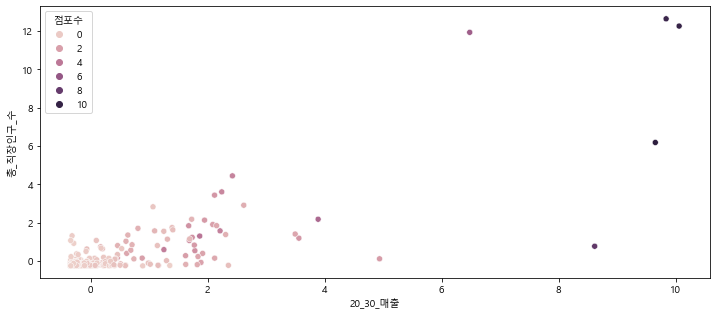

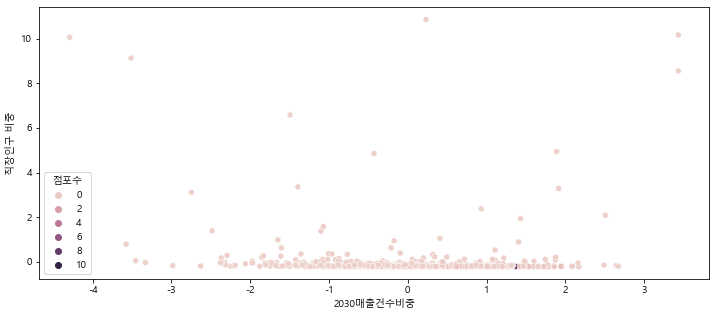

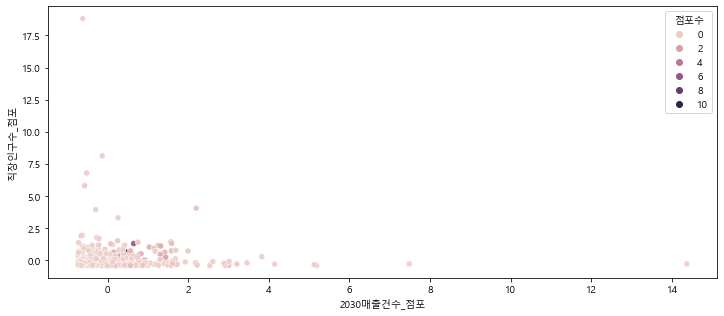

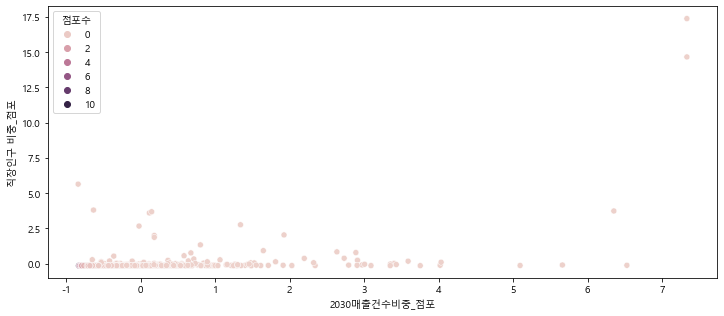

In [59]:
plt.figure(figsize=(12, 5))

sns.scatterplot(x='20_30_매출', y='총_직장인구_수', data=stand_scaled_df, hue='점포수')

plt.figure(figsize=(12, 5))

sns.scatterplot(x='2030매출건수비중', y='직장인구 비중', data=stand_scaled_df, hue='점포수')


plt.figure(figsize=(12, 5))

sns.scatterplot(x='2030매출건수_점포', y='직장인구수_점포', data=stand_scaled_df, hue='점포수')

plt.figure(figsize=(12, 5))

sns.scatterplot(x='2030매출건수비중_점포', y='직장인구 비중_점포', data=stand_scaled_df, hue='점포수')

KMeans(n_clusters=5)

<Figure size 1440x432 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='20_30_매출', ylabel='총_직장인구_수'>

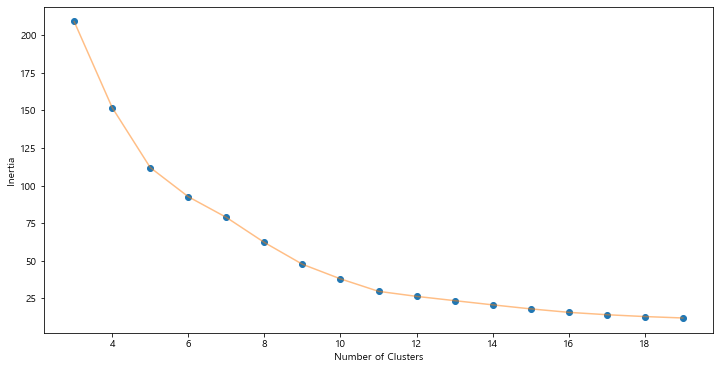

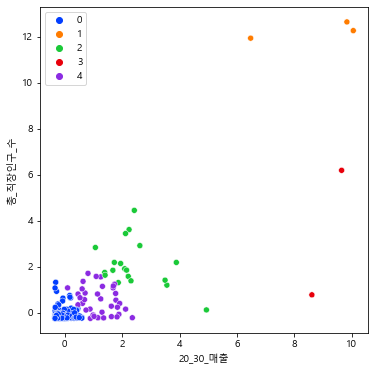

In [61]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(stand_scaled_df[["20_30_매출",'총_직장인구_수']])
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')


change_n_clusters(range(3,20), stand_scaled_df[["20_30_매출",'총_직장인구_수']])

kmeans = KMeans(n_clusters=5)
kmeans.fit(stand_scaled_df[["20_30_매출",'총_직장인구_수']])

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='20_30_매출', y='총_직장인구_수',hue= kmeans.labels_,data=stand_scaled_df[["20_30_매출",'총_직장인구_수']], palette='bright')